# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Student 1 - [johan.gjini@ulb.ac.be](mailto:student1@ulb.ac.be) - Student ID 000480821
### Student 2 - [lucas.weinberg@vub.ac.be](mailto:student2@ulb.ac.be) - Student ID 000400966
### Student 3 - [lionel.delchambre@ulb.ac.be](mailto:student3@ulb.ac.be) - Student ID 000336430

### Video presentation: www.youtube.com/abcd1234

## Project Title


# Introduction


# 1. Data preprocessing


### 1.1 Loading the data

In [29]:
install.packages(c('reshape2','future.apply','pROC','caret','ggplot2','dplyr','fastDummies','matlib','nnet','xgboost'))


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [56]:
library(fastDummies)
library(reshape2)
library(dplyr)
library(ggplot2)
library(tidyr)
library(future.apply)
library(caret)
library(pROC)
library(matlib)
library(nnet)
library(xgboost)


test_set=read.csv("test_set_features.csv",header=TRUE)                
training_label=read.csv("training_set_labels.csv",header=TRUE)
training_feature=read.csv("training_set_features.csv",header=TRUE)  

submission=read.csv("submission_format.csv",header = TRUE)

feature_df<-dplyr::tibble(training_feature)
labels_df<-dplyr::tibble(training_label)
training_df<-dplyr::inner_join(feature_df,labels_df)

Joining, by = "respondent_id"


Checking the data

In [57]:
dim(training_df)
#summary(training_df)


[1] 26707    38

Our training set is composed of 26707 rows and 38 variables (37 without id).


In [58]:
category_list=c()
not_category=c()
for (feature in colnames(training_df)){
  if (typeof(training_df[feature][[1]])=="character"){
    category_list<-c(category_list,feature)
  }
  else{
    not_category<-c(not_category, feature)  
  }    
}

not_category <- not_category[not_category!="respondent_id"]
all_features=c(category_list, not_category)

dummy_df <- training_df

#all_features

In [59]:

#replace empty strings by NA

for (col in category_list){
    dummy_df[,col][dummy_df[,col] == ""] <- NA
}

Mode <- function(x){
  #convert NA to most common value
  distinct_value <- unique(x[!is.na(x)])

  distinct_value[which.max(tabulate(match(x, distinct_value)))]
}





In [60]:
#convert categorical to numerical
for (c in category_list){
    
    dummy_df[[c]] <- unclass(factor(dummy_df[[c]]))
}

for (col in category_list){
    dummy_df[,col][is.na(dummy_df[,col])] <- Mode(dummy_df[,col])
}



head(dummy_df)



respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,⋯,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,1,0,0,0,0,0,0,1,1,⋯,1,2,9,3,0,0,13,20,0,0
1,3,2,0,1,0,1,0,1,1,⋯,2,1,2,1,0,0,13,20,0,1
2,1,1,0,1,0,0,0,0,0,⋯,1,1,10,1,2,0,15,22,0,0
3,1,1,0,1,0,1,1,0,0,⋯,2,2,6,2,0,0,13,20,0,1
4,2,1,0,1,0,1,1,0,1,⋯,1,1,10,1,1,0,19,6,0,0
5,3,1,0,1,0,1,0,0,1,⋯,1,1,1,2,2,3,16,19,0,0


In [61]:
df <- sapply(dummy_df[,all_features], as.numeric)

#Correlation matrix with Pearson method
cormat <- round(cor(df, method='pearson', use='complete.obs'),2)


#Put Correaltion matrix in a form suitable to build heatmap
melted_cormat <- melt(cormat)


summary(df)

   age_group       education          race           sex        income_poverty 
 Min.   :1.000   Min.   :1.000   Min.   :1.00   Min.   :1.000   Min.   :1.000  
 1st Qu.:2.000   1st Qu.:2.000   1st Qu.:4.00   1st Qu.:1.000   1st Qu.:1.000  
 Median :3.000   Median :3.000   Median :4.00   Median :1.000   Median :2.000  
 Mean   :3.186   Mean   :2.764   Mean   :3.57   Mean   :1.406   Mean   :1.788  
 3rd Qu.:5.000   3rd Qu.:4.000   3rd Qu.:4.00   3rd Qu.:2.000   3rd Qu.:3.000  
 Max.   :5.000   Max.   :4.000   Max.   :4.00   Max.   :2.000   Max.   :3.000  
                                                                               
 marital_status   rent_or_own    employment_status hhs_geo_region 
 Min.   :1.000   Min.   :1.000   Min.   :1.000     Min.   : 1.00  
 1st Qu.:1.000   1st Qu.:1.000   1st Qu.:1.000     1st Qu.: 4.00  
 Median :1.000   Median :1.000   Median :1.000     Median : 6.00  
 Mean   :1.492   Mean   :1.222   Mean   :1.547     Mean   : 5.83  
 3rd Qu.:2.000   3rd Qu.:

In [62]:
#normalizing the data
normalized_df <- df

replace_na_with_mean_value<-function(vec) {
    mean_vec<-mean(vec,na.rm=T)
    vec[is.na(vec)]<-mean_vec
    vec
}

for (col in not_category){
  normalized_df[ , col][is.na(normalized_df[ , col])] <- mean(normalized_df[ , col], na.rm = TRUE)
}


for (col in all_features){
  norm_factor=max(normalized_df[,col])
  normalized_df[,col]<-round((normalized_df[,col])/norm_factor, digits=3)
  
}




In [63]:
#mrmr filter

training_set <- read.csv("normalized_data.csv")

n <- ncol(training_set)
n_var <- n-2
input_variables <- training_set[,1:n_var]

output_variable <- training_set[,"h1n1_vaccine"]

correlation<-abs(cor(input_variables,output_variable))
selected<-c()
candidates<-1:n_var

for (j in 1:n_var) {
    redundancy_score<-numeric(length(candidates))
        
    if (length(selected)>0) {
        # Compute the correlation between the selected variables and the candidates on the training set
        cor_selected_candidates<-cor(training_set[,selected,drop=F],training_set[,candidates,drop=F])
        # Compute the mean correlation for each candidate variable, across the selected variables
        redundancy_score<-apply(cor_selected_candidates,2,mean)
    }
        
    # mRMR: minimum Redundancy Maximum Relevancy
    mRMR_score<-correlation[candidates]-redundancy_score
        
    
    # Select the candidate variable that maximises the mRMR score
    selected_current<-candidates[which.max(mRMR_score)]
    selected<-c(selected,selected_current)
    # Remove the selected variables from the candidates
    candidates<-setdiff(candidates,selected_current)
    

}



all_features[selected]




[1] "doctor_recc_seasonal"        "opinion_h1n1_risk"          
 [3] "h1n1_concern"                "health_insurance"           
 [5] "opinion_h1n1_sick_from_vacc" "employment_occupation"      
 [7] "opinion_h1n1_vacc_effective" "opinion_seas_sick_from_vacc"
 [9] "behavioral_antiviral_meds"   "rent_or_own"                
[11] "chronic_med_condition"       "income_poverty"             
[13] "opinion_seas_risk"           "health_worker"              
[15] "race"                        "behavioral_wash_hands"      
[17] "child_under_6_months"        "sex"                        
[19] "employment_status"           "h1n1_knowledge"             
[21] "household_children"          "doctor_recc_h1n1"           
[23] "education"                   "h1n1_vaccine"               
[25] "behavioral_avoidance"        "opinion_seas_vacc_effective"
[27] "behavioral_large_gatherings" "marital_status"             
[29] "census_msa"                  "employment_industry"        
[31] "age_group"                   "behavioral_face_mask"       
[33] "hhs_geo_region"              "household_adults"           
[35] "behavioral_touch_face"       "behavioral_outside_home"

## Missing value imputation

## Feature engineering

## Feature selection


# Model selection

The packages to be used for the model selection and implementation are given. Here follow these eight packages along with a short description:

a. **Stats/ridge** (linear/ridge models) - Ridge regression is almost like linear regression (sum of squares), except that few bias are integrated. It results that variance is significantly decreasing. The equation for Ridge regression penalty is sum of squared residuals + lambda x slope^2.

b. **Nnet** (neural networks)  – Simulates several densely interconnected cells. The computer can therefore learn, recognize patterns and make decisions.

c. **Tree/rpart** (decision trees)  – Can easily model nonlinear relationship. Decision trees model data as a tree of hierarchical branches. They make branches until they reach leaves that represent predictions. Unfortunately, decision trees suffer from a major flaw. If you allow them to grow limitlessly, they can completely memorize the training data, just from creating more and more and more branches.

d. **randomForest** (random forest)  – addresses decision tree issues. It trains a large number of strong decision trees and combine their predictions through bagging (i.e. using complex base models and try to smooth out their prediction). There are two sources of randomness: each tree is only allowed to choose from a random subset of features to split on (leading to feature selection) and each tree is only trained on a random subset of observation (process called resampling).

e. **RSNNS** (radial basis functions) – R Stuttgart Neural Network Simulator , is a comprehensive application for neural network model building, training and testing. The package provides high flexibility for using neural network in R (with interface and tools for visualization and analysis of training).

f. **Lazy**  – Learning method in which the generalization of the training data is delayed till a query is made to the system. Lazy classifiers are most useful for large, continuously changing datasets with few attributes. They do not have training phase.

g. **e1071** - Functions for latent class analysis, short time Fourier transform, fuzzy clustering, support vector machines, shortest path computation, bagged clustering, naive Bayes classifier, generalized k-nearest neighbour.

h. **glmnet** (Lasso/elasticNet models)  – Lasso regression is almost the same as ridge regression, except that the ridge regression penalty used the absolute value of the slope. The equation is then sum of squared residuals + lambda x abs(slope). Elastic net regression is the combination of lasso and ridge regression.


The following criteria must be considered to select machine learning methods adapted to a specific problem: 

- *Objective*: classification or regression. Regression forecasts future by estimating the relationship between variables. Classification identifies what category new information belongs in. 

- *Interpretability*: ability to explain its prediction. Algorithm lacking the ability to explain its decision pattern is called a black box.

- *Number of data points and features*: size of the data and number of features. Neural network can handle big dataset. Support vector machine can work with limited number of features.

- *Data format*: numerical, categorical. 

- *Linearity of data*: linear, non linear. 

- *Training and prediction time*: time take by the algorithm to learn and create the model, time to predict the result based on the model.

- *Other criteria¨*: memory requirements, etc.

The machine learning methods provided by the mandatory packages have been defined according to the previous criteria. The problem stated by Flu Shot Learning: Predicting H1N1 and Seasonal Influenza Vaccines is a classification problem with 37 features and approximately 26,000 labels. There is no need to optimize training or prediction time. Based on these criteria, we decided to implement the following three models:

Model 1: RandomForest 

Model 2: K-Nearest Neighbours 

Model 3: Neural network 

## Model 1 - RandomForest



## Model 2 - KNN

Since the K-Nearest Neighbors algorithm is an algorithm which works well when there are low overlapping between the different class and which doesen't like unnormalized data. A personnalized feature preprocessing, engineering and selection has been achieved for this method. The feature selection is based on the Linear Discriminant Analysis (LDA) which replaced the mrMR method for feature selection.

### Feature preprocessing for KNN

Instead of hotcoding for categorical variable dummy coding has been achieved missing value are thus not needed to be handled anymore for categorical value and we replaced missing values in numerical feature with the mean of the feature.


In [90]:
#Dataframe creation to use dplyr workframe :

feature_df<-dplyr::tibble(training_feature)
labels_df<-dplyr::tibble(training_label)
training_df<-dplyr::inner_join(feature_df,labels_df)
test_df<-dplyr::tibble(test_set)
#Converting categorical to binary and converting NaN value to mean -> fastDummies::dummy_cols does the job

category_list=c()
for (feature in colnames(training_df)){
  if (typeof(training_df[feature][[1]])=="character"){
    category_list<-c(category_list,feature)
  }
}
category_list

#Create dummy variable and suppress one dummy per categorycal feature to avoid future colinearity problem
#with regard to LDA
dummy_df<-fastDummies::dummy_cols(training_df,remove_first_dummy = TRUE)
no_category_df<-dplyr::select(dummy_df,!category_list)

# Replace NaN value for numerical features with the mean of the feature
replace_na_with_mean_value<-function(vec) {
  mean_vec<-mean(vec,na.rm=T)
  vec[is.na(vec)]<-mean_vec
  vec
}
df_preprocessed<-data.frame(apply(no_category_df,2,replace_na_with_mean_value))

Joining, by = "respondent_id"


[1] "age_group"             "education"             "race"                 
 [4] "sex"                   "income_poverty"        "marital_status"       
 [7] "rent_or_own"           "employment_status"     "hhs_geo_region"       
[10] "census_msa"            "employment_industry"   "employment_occupation"

### Feature selection

Before applying the LDA feature selection we look for correlation between the feature to avoid redundance of information since LDA does not take care of it. 

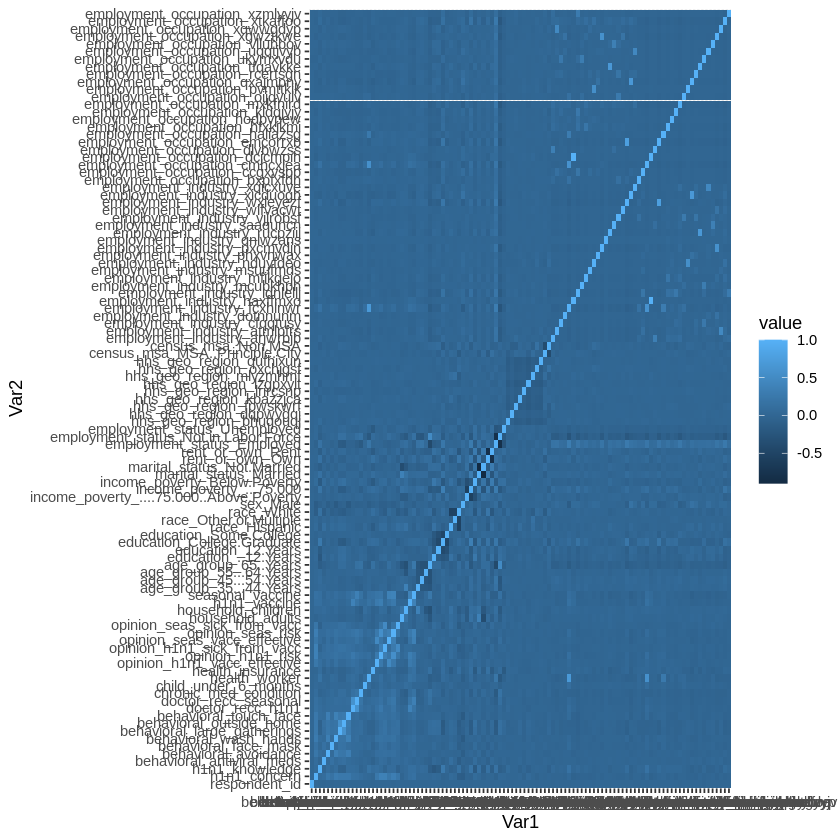

In [91]:
#Correlation matrix with Pearson method
cormat <- round(cor(df_preprocessed, method='pearson'),2)

#Put Correaltion matrix in a form suitable to build heatmap
melted_cormat <- melt(cormat)

#Heatmap
pearson_heatmap<-ggplot(data = melted_cormat, aes(x=Var1, y=Var2, fill=value)) + 
  geom_tile()
pearson_heatmap

In [92]:
#Check for highly correlated value (>0.8)
high_correl_variable<-dplyr::filter(melted_cormat,abs(value)>0.8)
high_correl_variable<-dplyr::filter(high_correl_variable,Var1!=Var2)
high_correl_variable

Var1,Var2,value
<fct>,<fct>,<dbl>
marital_status_Not.Married,marital_status_Married,-0.90
marital_status_Married,marital_status_Not.Married,-0.90
rent_or_own_Rent,rent_or_own_Own,-0.82
rent_or_own_Own,rent_or_own_Rent,-0.82
employment_occupation_dcjcmpih,employment_industry_haxffmxo,1.00
employment_industry_haxffmxo,employment_occupation_dcjcmpih,1.00


We chose to suppress arbitrarily one of the two highly correlated feature.

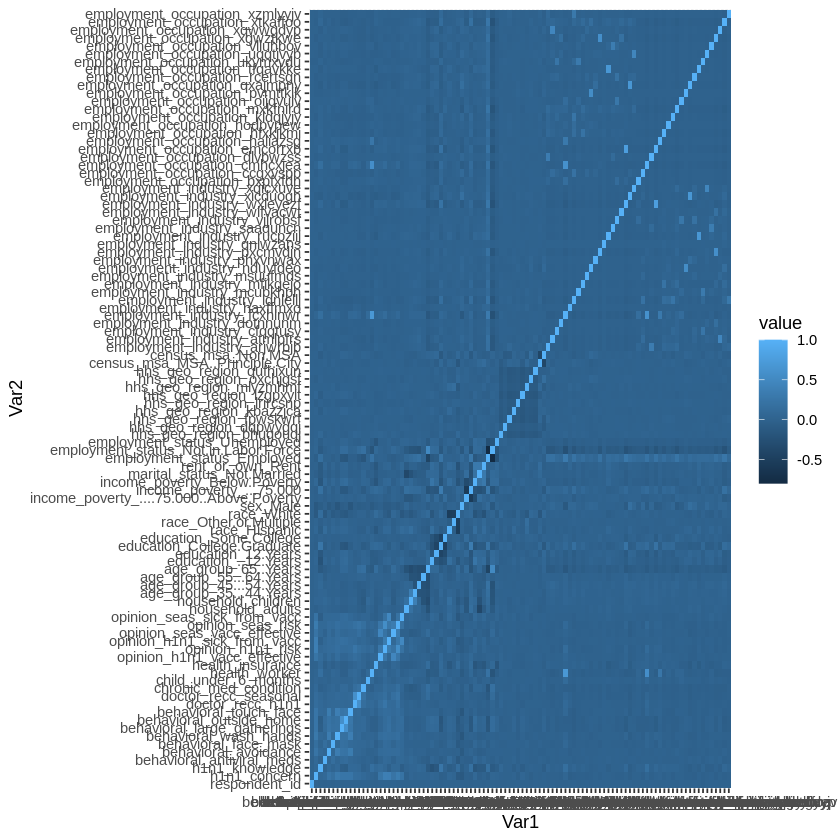

In [93]:
# When two feature are highly correlated we could keep only one of the two <- only old character field are concerned 
droped_variable<-c('marital_status_Married','employment_occupation_dcjcmpih','rent_or_own_Own')
first_selection_df<-dplyr::select(df_preprocessed,-droped_variable)
first_selection_df<-dplyr::select(first_selection_df,-c('h1n1_vaccine','seasonal_vaccine'))

#Rebuild new Heatmap after feature suppression
cormat <- round(cor(first_selection_df, method='pearson'),2)
melted_cormat <- melt(cormat)
pearson_heatmap<-ggplot(data = melted_cormat, aes(x=Var1, y=Var2, fill=value)) + 
  geom_tile()
pearson_heatmap

#### The personalized LDA usage
Now that this has been achieved, lets dive into Linear Discriminant Analysis. In its boolean two class version ($C_1$,$C_2$), the aim of LDA is to find the axis which would best separate the two class when projecting all the point onto it. As it is represented in the following image for a two feature exemple 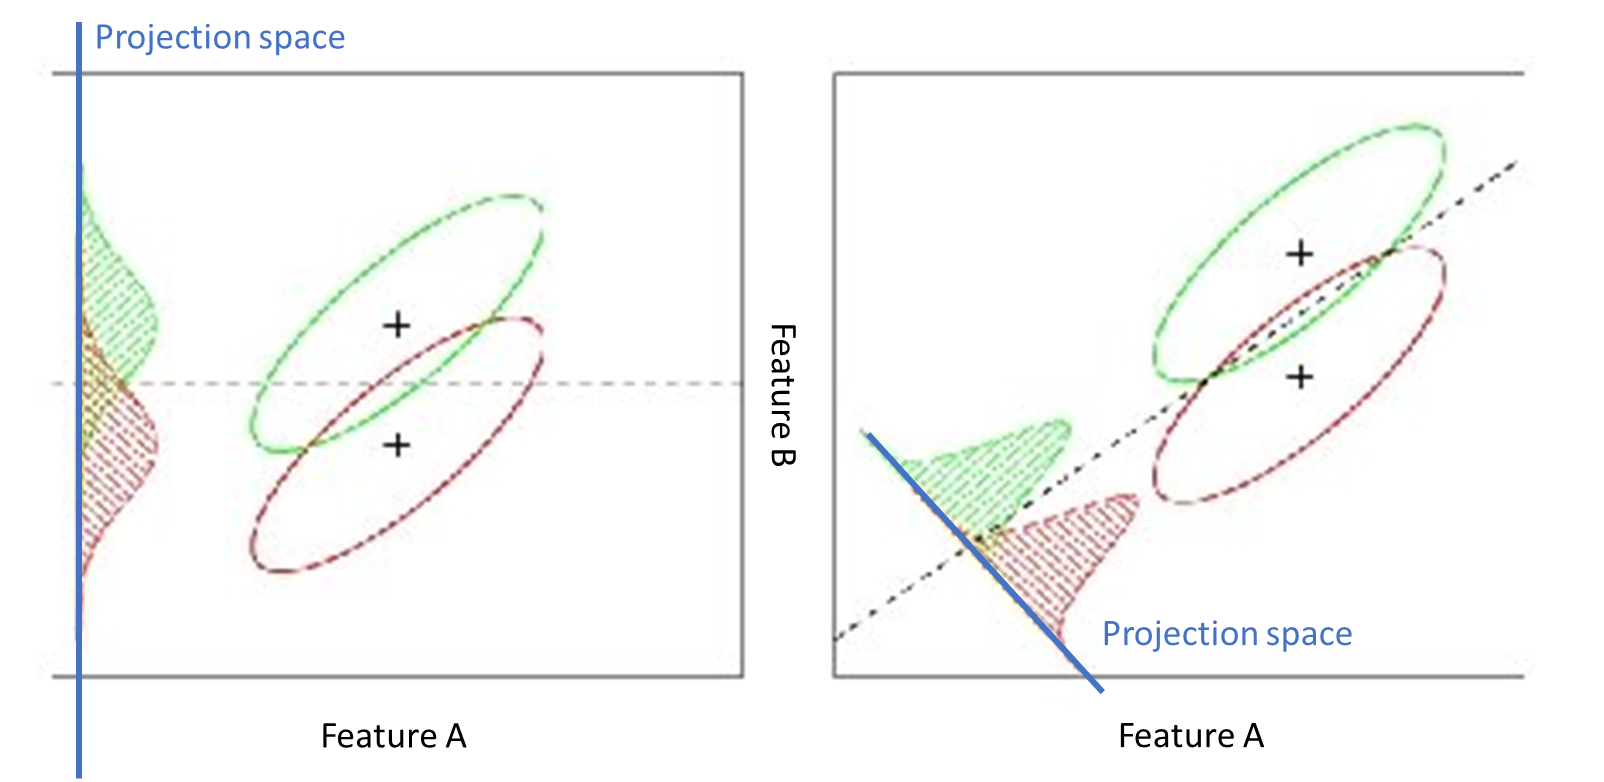
On the left the y axis is chosen as projection space on the right the best projection for separating the data is chosen.

In its mathematical formulation this is retranscribed, after projecting points onto the linear subspace of director vector $v_p$, as maximising the squared distance between the two class centroid $(\mu_1-\mu_2)^2$ while minimizing their respective variance $\sigma_1^2+\sigma_2^2$. These two quantity can be rewrited in terms of the between-class scatter matrix $S_b$ and the within-class scater matrix $S_w$ as
\begin{equation*}
\begin{aligned}
(\mu_1-\mu_2)^2&=v_p^tS_bv_p\\
\sigma_1^2+\sigma_2^2&=v_p^tS_wv_p
\end{aligned}
\end{equation*} 

where $S_b$ and $S_w$ can be written in term of the real class mean $m_1$ and $m_2$ as

\begin{equation*}
\begin{aligned}
S_b&=(m_1-m_2)(m_1-m_2)^t\\
S_w&=\sum_{x_i\in C_1}(x_i-m_1)(x_i-m_1)^t+\sum_{x_i\in C_2}(x_i-m_2)(x_i-m_2)^t
\end{aligned}
\end{equation*}

The whole picture can then be resumed as an optimization problem of the form

\begin{equation*}
\begin{aligned}
\max_{v:|v|=1} \frac{v^TS_bv}{v^TS_wv}
\end{aligned}
\end{equation*}

Which can be solved by looking at the eigenvalue problem 

\begin{equation}
\begin{aligned}
\lambda_pv_p&=S_w^{-1}S_bv_p\\
&=S_w^{-1}(m_1-m_2)\underbrace{(m_1-m_2)^tv_p}_{scalar}\\
\Rightarrow\  v_p&\propto S_w^{-1}(m_1-m_2)
\end{aligned}
\end{equation}
This algorithm is usually used to classify the data with repect to a singel treshold after projecting the data on the right defined by $v_p$ but we chose to use $v_p$ as a tool to select useful feature for the KNN algorithm.

Indeed since $v_p$ represent the direction who would lead to the least overlaping between our two class it means that its component are a direct measure of the overlaping of each class in the different feature. We can then chose to only keep feature whose component in $v_p$ are higher than an arbitrary threshold $x_t$ which then becomes an hyperparameter of our model.

That being said lets start the LDA fetaure selection, it is common to normalize and center the data before applying the above technique :

In [94]:
#Normalization of the feature to [0,1]

for (feature in colnames(first_selection_df)){
  if (feature!='respondent_id'){
  norm_factor=max(first_selection_df[feature])
  first_selection_df[feature]<-(first_selection_df[feature])/norm_factor
  }
}
#Get the mean of each feature to be able to center the data and get the id out of the way
mean_vector<-apply(dplyr::select(first_selection_df,-'respondent_id'),2,mean)
head(mean_vector)

#Center the data
centered_df<-sweep(dplyr::select(first_selection_df,-'respondent_id'),MARGIN = 2,STATS = mean_vector,FUN = '-')
#Bring the id back
centered_df['respondent_id']<-first_selection_df['respondent_id']

#Check that it is indeed centered
mean_centered<-apply(centered_df,2,mean)
head(mean_centered)

h1n1_concern            h1n1_knowledge behavioral_antiviral_meds 
               0.53949527                0.63126622                0.04884367 
     behavioral_avoidance      behavioral_face_mask     behavioral_wash_hands 
               0.72561229                0.06898231                0.82561410

h1n1_concern            h1n1_knowledge behavioral_antiviral_meds 
            -1.508495e-17             -3.687323e-17              1.512812e-18 
     behavioral_avoidance      behavioral_face_mask     behavioral_wash_hands 
            -5.085459e-17             -1.078969e-18              3.550875e-17

Lets compute $m_1$, $m_2$ and separate the point coordinate $x_i$ with repect to their class appartenance

In [95]:
#Bringing the labels back in the picture
h1n1_centered<-dplyr::inner_join(centered_df,df_preprocessed[c('respondent_id','h1n1_vaccine')])
seasonal_centered<-dplyr::inner_join(centered_df,df_preprocessed[c('respondent_id','seasonal_vaccine')])

#Get the mean when grouping with respect to label value (=mean per category m_1 and m_2) :  
h1n1_col_means_class<-h1n1_centered%>% group_by(h1n1_vaccine)%>% summarise(across(.cols = -c('respondent_id'), .fns = mean))
seasonal_col_means_class<-seasonal_centered%>% group_by(seasonal_vaccine)%>% summarise(across(.cols = -c('respondent_id'), .fns = mean))

h1n1_m0<-data.matrix(dplyr::select(h1n1_col_means_class%>%filter(h1n1_vaccine==0),-'h1n1_vaccine'))
h1n1_m1<-data.matrix(dplyr::select(h1n1_col_means_class%>%filter(h1n1_vaccine==1),-'h1n1_vaccine'))
  
seasonal_m0<-data.matrix(dplyr::select(seasonal_col_means_class%>%filter(seasonal_vaccine==0),-'seasonal_vaccine'))
seasonal_m1<-data.matrix(dplyr::select(seasonal_col_means_class%>%filter(seasonal_vaccine==1),-'seasonal_vaccine'))
#Get the covariance matrix for each -> create matrix

centered_h1n1_0<-data.matrix(dplyr::select(h1n1_centered %>% filter(h1n1_vaccine==0),-c('respondent_id','h1n1_vaccine')))
centered_h1n1_1<-data.matrix(dplyr::select(h1n1_centered %>% filter(h1n1_vaccine==1),-c('respondent_id','h1n1_vaccine')))

centered_seasonal_0<-data.matrix(dplyr::select(seasonal_centered %>% filter(seasonal_vaccine==0),-c('respondent_id','seasonal_vaccine')))
centered_seasonal_1<-data.matrix(dplyr::select(seasonal_centered %>% filter(seasonal_vaccine==1),-c('respondent_id','seasonal_vaccine')))

Joining, by = "respondent_id"
Joining, by = "respondent_id"


We have now all what is needed to define $S_b$ and $S_w$ 

In [96]:
#Get the between-class scatter matrix S_b
h1n1_Sb<-(t(h1n1_m0-h1n1_m1))%*%(h1n1_m0-h1n1_m1)
seasonal_Sb<-(t(seasonal_m0-seasonal_m1))%*%(seasonal_m0-seasonal_m1)
# Get the  within-class scatter matrix S_w
h1n1_cov0 <- (t(centered_h1n1_0) %*% centered_h1n1_0)
h1n1_cov1 <- (t(centered_h1n1_1) %*% centered_h1n1_1)

seasonal_cov0 <- (t(centered_seasonal_0) %*% centered_seasonal_0)
seasonal_cov1 <- (t(centered_seasonal_1) %*% centered_seasonal_1)

h1n1_Sw <- h1n1_cov0 + h1n1_cov1
seasonal_Sw = seasonal_cov0 + seasonal_cov1

All what remains to do is to invert $S_w$ and compute $v_p$ 

In [97]:
#Obtain the director vector of the best linear projection

#first invert Sw 
Sw_invert_h1n1<-inv(h1n1_Sw)
Sw_invert_seasonal<-inv((seasonal_Sw))

#Our director vector will be proportionnal to

v_h1n1_unormalized<-Sw_invert_h1n1%*%t(h1n1_m0-h1n1_m1)
v_seasonal_unormalized<-Sw_invert_seasonal%*%t(seasonal_m0-seasonal_m1)

#Lets noramlize it

v_h1n1<-v_h1n1_unormalized/sqrt((t(v_h1n1_unormalized)%*%v_h1n1_unormalized)[1])
v_seasonal<-v_seasonal_unormalized/sqrt((t(v_seasonal_unormalized)%*%v_seasonal_unormalized)[1])

We can now chose an arbitrary threshold $x_t$ and select feature whose component in $v_p$ are bigger than $x_t$

In [99]:
#Lets choose an arbitrary tresholds x_t to keep only component(=feature) of the vector who are above it 
#threshold=0.05

selector_h1n1<-abs(v_h1n1)>0.05
selector_seasonal<-abs(v_seasonal)>0.05

LDA_dummy_feature_h1n1<-colnames(dplyr::select(centered_df,-'respondent_id')[,selector_h1n1[,1]])
LDA_dummy_feature_seasonal<-colnames(dplyr::select(centered_df,-'respondent_id')[,selector_seasonal[,1]])

#The actual kept feature
LDA_dummy_feature_h1n1
LDA_dummy_feature_seasonal

[1] "h1n1_concern"                   "doctor_recc_h1n1"              
 [3] "doctor_recc_seasonal"           "health_worker"                 
 [5] "health_insurance"               "opinion_h1n1_vacc_effective"   
 [7] "opinion_h1n1_risk"              "opinion_seas_risk"             
 [9] "opinion_seas_sick_from_vacc"    "age_group_55...64.Years"       
[11] "age_group_65..Years"            "race_Other.or.Multiple"        
[13] "employment_industry_arjwrbjb"   "employment_industry_fcxhlnwr"  
[15] "employment_industry_haxffmxo"   "employment_industry_nduyfdeo"  
[17] "employment_industry_phxvnwax"   "employment_industry_saaquncn"  
[19] "employment_industry_wxleyezf"   "employment_industry_xicduogh"  
[21] "employment_occupation_hfxkjkmi" "employment_occupation_pvmttkik"
[23] "employment_occupation_qxajmpny" "employment_occupation_tfqavkke"

[1] "h1n1_knowledge"                 "doctor_recc_h1n1"              
 [3] "doctor_recc_seasonal"           "health_worker"                 
 [5] "health_insurance"               "opinion_seas_vacc_effective"   
 [7] "opinion_seas_risk"              "opinion_seas_sick_from_vacc"   
 [9] "age_group_45...54.Years"        "age_group_55...64.Years"       
[11] "age_group_65..Years"            "race_Other.or.Multiple"        
[13] "race_White"                     "employment_industry_arjwrbjb"  
[15] "employment_industry_atmlpfrs"   "employment_industry_dotnnunm"  
[17] "employment_industry_fcxhlnwr"   "employment_industry_haxffmxo"  
[19] "employment_industry_mfikgejo"   "employment_industry_msuufmds"  
[21] "employment_industry_phxvnwax"   "employment_industry_pxcmvdjn"  
[23] "employment_industry_wlfvacwt"   "employment_industry_xicduogh"  
[25] "employment_occupation_bxpfxfdn" "employment_occupation_oijqvulv"
[27] "employment_occupation_qxajmpny" "employment_occupation_ukymxvdu"
[29] "employment_occupation_uqqtjvyb" "employment_occupation_xgwztkwe"

In [100]:
# Since many of this feature are boolean created from categorical feature we can group them back under the original feature name
LDA_feature_h1n1<-c(colnames(feature_df[,colnames(feature_df)%in%LDA_dummy_feature_h1n1]),'employment_industry','age_group','employment_occupation')
LDA_feature_seasonal<-c(colnames(feature_df[,colnames(feature_df)%in%LDA_dummy_feature_seasonal]),'employment_industry','age_group','employment_occupation')

LDA_feature_h1n1
LDA_feature_seasonal

[1] "h1n1_concern"                "doctor_recc_h1n1"           
 [3] "doctor_recc_seasonal"        "health_worker"              
 [5] "health_insurance"            "opinion_h1n1_vacc_effective"
 [7] "opinion_h1n1_risk"           "opinion_seas_risk"          
 [9] "opinion_seas_sick_from_vacc" "employment_industry"        
[11] "age_group"                   "employment_occupation"

[1] "h1n1_knowledge"              "doctor_recc_h1n1"           
 [3] "doctor_recc_seasonal"        "health_worker"              
 [5] "health_insurance"            "opinion_seas_vacc_effective"
 [7] "opinion_seas_risk"           "opinion_seas_sick_from_vacc"
 [9] "employment_industry"         "age_group"                  
[11] "employment_occupation"

Now that this preprocessing has been achieved we can start hard coding our KNN algorithm

In [104]:
#KNN algorithm. Remark: creation of a ball-tree could greatly enhance trainign speed but hardcode one 
#would take me way to much time.

#future apply is a parallelization package for apply() function
library(future.apply)
plan(multisession)


#Minkowski metrix p=1 : Manhatan distance, p=2 : euclidean distance
minkowski<-function(a,b,p){
  sum((abs(b-a)^p)^(1/p))
}

#Nearest neighbor algorithm for a point.
nearest_neighbors = function(obs,train_matrix, k, FUN,p,flu_type,id){
  distance =future_apply(train_matrix,1, FUN,obs,p)
  distances = sort(distance,method='quick')
  neighbor_ind = which(distance %in% distances[1:k])
  #Define probability as the mean of the label of the neighbors  
  if (flu_type=='h1n1_vaccine'){
    proba=mean(id$h1n1_vaccine[neighbor_ind])
  }
  if (flu_type=='seasonal_vaccine'){
    proba=mean(id$seasonal_vaccine[neighbor_ind])
  }
  return(proba)
  }
#Application of nearest neighbors to each point of the test set
knn_proba=function(test_matrix_1,train_matrix_1,k,p,flu_type,id){
  proba_matrix=future_apply(test_matrix_1,1,nearest_neighbors,train_matrix_1,k,minkowski,p,flu_type,id)
  return(proba_matrix)
}

Lets now make use AUC as the metric for tuning our two hyperparameter $p_{mink}$ and $n_{neighbor}$ using leave one out technique on our training set

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC-ROC curves for"                     
[2] "5"                                      
[3] "neighbors and minkowski metrix of order"
[4] "1"                                      
[5] "is"                                     
[6] "0.799235603513684"                      


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC-ROC curves for"                     
[2] "5"                                      
[3] "neighbors and minkowski metrix of order"
[4] "2"                                      
[5] "is"                                     
[6] "0.798731476362729"                      


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC-ROC curves for"                     
[2] "10"                                     
[3] "neighbors and minkowski metrix of order"
[4] "1"                                      
[5] "is"                                     
[6] "0.826535141554713"                      


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC-ROC curves for"                     
[2] "10"                                     
[3] "neighbors and minkowski metrix of order"
[4] "2"                                      
[5] "is"                                     
[6] "0.822265415088473"                      


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC-ROC curves for"                     
[2] "25"                                     
[3] "neighbors and minkowski metrix of order"
[4] "1"                                      
[5] "is"                                     
[6] "0.826532635219598"                      


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC-ROC curves for"                     
[2] "25"                                     
[3] "neighbors and minkowski metrix of order"
[4] "2"                                      
[5] "is"                                     
[6] "0.836633750231477"                      


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC-ROC curves for"                     
[2] "50"                                     
[3] "neighbors and minkowski metrix of order"
[4] "1"                                      
[5] "is"                                     
[6] "0.832428952763203"                      


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC-ROC curves for"                     
[2] "50"                                     
[3] "neighbors and minkowski metrix of order"
[4] "2"                                      
[5] "is"                                     
[6] "0.8312640511173"                        


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC-ROC curves for"                     
[2] "100"                                    
[3] "neighbors and minkowski metrix of order"
[4] "1"                                      
[5] "is"                                     
[6] "0.830777997522241"                      


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC-ROC curves for"                     
[2] "100"                                    
[3] "neighbors and minkowski metrix of order"
[4] "2"                                      
[5] "is"                                     
[6] "0.835476474320064"                      
[1] "our best hyperparameter are k="  "25"                             
[3] "for minkowski distance of order" "2"                              
[1] "The corresponding ROC curves are :"


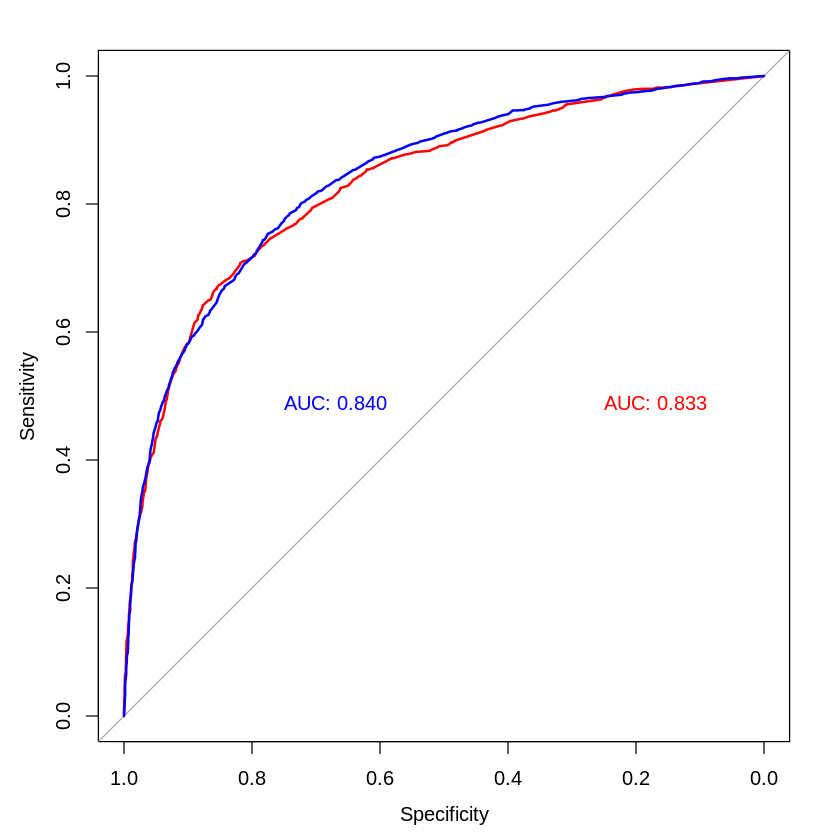

In [105]:
#DISCLAIMER : THIS BLOCK WILL TAKE SEVERAL MINUT TO AN HOUR TO RUN !!!

#library pROC to plot ROC curve and compute AUC for hyperparameter tuning
library(pROC)

#Select only the relevant feature from LDA.
h1n1_centered=dplyr::select(h1n1_centered,all_of(LDA_dummy_feature_h1n1))
seasonal_centered=dplyr::select(seasonal_centered,all_of(LDA_dummy_feature_seasonal))


#Put the data in matricial form for commodity.
h1n1_matrix=data.matrix(h1n1_centered)
seasonal_matrix=data.matrix(seasonal_centered)

#Start of leave one out hyperparameter tuning.
best_mean=0
for (nbr_neighbor in c(5,10,25,50,100)){
  for (p_mink in c(1,2)){
    #Define train and test sample from training sample.
    training_label.samples <- training_label$respondent_id%>%createDataPartition(p = 0.8, list = FALSE)
    train_h1n1.data  = h1n1_matrix[training_label.samples, ]
    test_h1n1.data = h1n1_matrix[-training_label.samples, ]
    train_seasonal.data  = seasonal_matrix[training_label.samples, ]
    test_seasonal.data = seasonal_matrix[-training_label.samples, ]
    test_label_frame=training_label[-training_label.samples,]
    training_label_frame=training_label[training_label.samples,]
      
    # Build the model proba.
    h1n1_proba=knn_proba(test_h1n1.data,train_h1n1.data,nbr_neighbor,p_mink,'h1n1_vaccine',training_label_frame)
    seasonal_proba=knn_proba(test_seasonal.data,train_seasonal.data,nbr_neighbor,p_mink,'seasonal_vaccine',training_label_frame)
    
    #Compute the AUC-ROC curve.
    roc_h1n1=roc(test_label_frame$h1n1_vaccine, h1n1_proba,auc=TRUE)
    roc_seasonal=roc(test_label_frame$seasonal_vaccine, seasonal_proba,auc=TRUE)
    actual_mean=mean(mean(c(auc(roc_h1n1),auc(roc_seasonal))))
    print(unlist(list('AUC-ROC curves for' , nbr_neighbor,'neighbors and minkowski metrix of order',p_mink,'is',actual_mean)))
    if (actual_mean>best_mean)
    {
      best_mean=actual_mean
      best_roc_h1n1=roc_h1n1
      best_roc_seasonal=roc_seasonal
      p_best=p_mink
      n_best=nbr_neighbor
    }
  }
}
#Plot best ROC curve with AUC
print(unlist(list('our best hyperparameter are k=',n_best,'for minkowski distance of order',p_best)))
print('The corresponding ROC curves are :')
plot.roc(best_roc_h1n1,print.auc=TRUE,print.auc.x=0.25, print.auc.y=0.5,col='red')
plot.roc(best_roc_seasonal,add=TRUE,print.auc=TRUE,print.auc.x=0.75, print.auc.y=0.5,col = 'blue')

Lets then see what score our best model get in the competition to do so we need to make the test set go through the preprocessing pipeline :

In [109]:
#First need to put the test data in the same form as the training set = data pipeline
test_dummy_df<-fastDummies::dummy_cols(test_df,remove_first_dummy = TRUE)
test_int_df<-dplyr::select(test_dummy_df,!category_list)
test_df_preprocessed<-data.frame(apply(test_int_df,2,replace_na_with_mean_value))
test_selection_df<-dplyr::select(test_df_preprocessed,-droped_variable)

for (feature in colnames(test_selection_df)){
  if (feature!='respondent_id'){
    norm_factor=max(test_selection_df[feature])
    test_selection_df[feature]<-(test_selection_df[feature])/norm_factor
  }
}
test_mean_vector<-apply(dplyr::select(test_selection_df,-'respondent_id'),2,mean)
test_centered_df<-sweep(dplyr::select(test_selection_df,-'respondent_id'),MARGIN = 2,STATS = test_mean_vector,FUN = '-')
test_mean_centered<-apply(test_centered_df,2,mean)

test_centered_h1n1=dplyr::select(test_centered_df,all_of(LDA_dummy_feature_h1n1))
test_centered_seasonal=dplyr::select(test_centered_df,all_of(LDA_dummy_feature_seasonal))


test_h1n1_matrix=data.matrix(test_centered_h1n1)
test_seasonal_matrix=data.matrix(test_centered_seasonal)


In [111]:
h1n1_best=knn_proba(test_h1n1_matrix,h1n1_matrix,n_best,p_best,'h1n1_vaccine',training_label)
seasonal_best=knn_proba(test_seasonal_matrix,seasonal_matrix,n_best,p_best,'seasonal_vaccine',training_label)
full_matrix=do.call("cbind", list(test_set$respondent_id, h1n1_best,seasonal_best))
return_frame=tibble('respondent_id'=full_matrix[,1],'h1n1_vaccine'=full_matrix[,2],'seasonal_vaccine'=full_matrix[,3])
write.csv(return_frame,'knn_best', row.names = FALSE)

Competition score : 0.8255

## Model 3 - Neural network



In [114]:
training<-read.csv('normalized_training.csv',header=TRUE)

label<-read.csv('training_set_labels.csv',header=TRUE)

test<-read.csv('normalized_test.csv',header=TRUE)

#training and label sets must not contain respondent_id
#upload the normalized datasets
training<-training_dflabel<-labels_df
test<-test_set


ERROR: Error in nnet(x = training, y = label_seasonal, size = 14, maxiter = 1000): impossible de trouver la fonction "nnet"


In [ ]:
#remove the id_respondent column for datasets to be used in the nnet function
training <- training[,2:36]
test <- test[,2:36]

#nnet will work with one single final neuron. Select the relevant label neuron
label_h1n1 <- label[,2]
label_seasonal <- label[,3]

nnet is a function computing a neural network trained on a training set to be categorized based on training labels. The S3 default method is used. In that case, the main inputs are:

    x - data.frame of training inputs
    y - data.frame of targeted values
    weights - case weights for each example (if missing, defaults to 1) In our project, we decide to use the default value
    size - defines the number of intermediate neurons. It seems that the number of weights cannot exceed a certain amount, therefore the total number of neurons (first and second layer) is also limited.
    na.action - to define actions in case of na. As datasets are completed, this function is not needed

In [ ]:
#nnet is a function computing the neural network model based on a training dataset and training labelset. There is one layer of 14 intermediary neurons
mynet_h1n1<-nnet(x=training,y=label_h1n1, size=14, maxiter=100)

In [ ]:
#predict function uses the previously computed neural network and applies it to a test set to predict the labels
ypred_h1n1 <- predict (mynet_h1n1, test)


In [ ]:
#same us of nnet and predict for the seasonal label set
mynet_seasonal<-nnet(x=training,y=label_seasonal, size=14, maxiter=1000)
ypred_seasonal <- predict (mynet_seasonal, test)

In [ ]:
#create data.frame and csv submission file
submit<-data.frame(label[,1],ypred_h1n1,ypred_seasonal)
write.csv(submit,"C:/Users/Admin/Documents/ULB/Cours/INFO-F422/Projet/submit.csv", row.names = TRUE)

#### Example of simple equation
\begin{equation}
e = mc^2
\end{equation}

#### Example of matrix equation - Cross product formula:

\begin{equation*}
\mathbf{V}_1 \times \mathbf{V}_2 =  \begin{vmatrix}
\mathbf{i} & \mathbf{j} & \mathbf{k} \\
\frac{\partial X}{\partial u} &  \frac{\partial Y}{\partial u} & 0 \\
\frac{\partial X}{\partial v} &  \frac{\partial Y}{\partial v} & 0
\end{vmatrix}
\end{equation*}

#### Example of multiline equation - The Lorenz Equations:

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

#### Example of Markdown Table:

| This | is   |
|------|------|
|   a  | table|


# Alternative models





# Conclusions